# RNN for Classifying Names - Solution

Note: This notebook follows in large parts  the notebook from Sean Robertson which you can find here:`<https://github.com/spro/practical-pytorch>`

We will be building and training a basic character-level RNN to classify
words. A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

### Preparing the Data

Download the data from here
   ` <https://download.pytorch.org/tutorial/data.zip>`
   and extract it to the `data` directory.

Included in the ``data/names`` directory are 18 text files named as
``[Language].txt``. Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We first get all the filenames:

In [1]:
import glob
filenames = glob.glob('../data/names/*.txt')

print(filenames)

['../data/names/Czech.txt', '../data/names/German.txt', '../data/names/Arabic.txt', '../data/names/Japanese.txt', '../data/names/Chinese.txt', '../data/names/Vietnamese.txt', '../data/names/Russian.txt', '../data/names/French.txt', '../data/names/Irish.txt', '../data/names/English.txt', '../data/names/Spanish.txt', '../data/names/Greek.txt', '../data/names/Italian.txt', '../data/names/Portuguese.txt', '../data/names/Scottish.txt', '../data/names/Dutch.txt', '../data/names/Korean.txt', '../data/names/Polish.txt']


And save each language as a category:

In [2]:
import os
all_categories = []


for filename in filenames:
    language = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(language)

print(all_categories)

['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']


Next we load the data and put every name in a list together and its category (=label) in a second list:

In [3]:
X = []
y = []


for index, filename in enumerate(filenames):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    category = all_categories[index]
    for line in lines:
        X.append(line)
        y.append(category)

n_categories = len(all_categories)
n_categories, len(X)

(18, 20074)

In [4]:
all_characters = set([c for name in X for c in name])
all_characters = set([c for name in X for c in name])
print(all_characters)
print(len(all_characters), "characters")

{'\xa0', "'", 'ł', 'p', 'b', '-', 'q', 'r', 'K', 'ä', 'D', 'n', 'ì', 'ê', 'o', 'W', 'E', 'k', 'a', 'C', 'w', 'M', 'i', 'ã', 'J', 'É', 'S', 'ò', 'ż', 'õ', '/', 'h', 'Q', 'e', 'O', 'á', ':', 'ó', 'ü', 'Á', '1', 'ń', 'R', 'A', 'ß', 'ú', 'P', 'G', 'ù', 'H', ',', 'I', ' ', 'à', 't', 'ą', 'é', 'X', 'Ż', 's', 'B', 'x', 'l', 'V', 'f', 'Y', 'ç', 'T', 'y', 'm', 'í', 'z', 'U', 'd', 'è', 'v', 'L', 'ñ', 'Z', 'g', 'j', 'Ś', 'c', 'N', 'u', 'ö', 'F'}
87 characters


We see that the files contain many special characters that make our problem more difficult. To reduce the character count, we only allow ASCII symbols:

In [5]:
import string

# these is the vocabulary we will use
all_letters = string.ascii_letters
n_letters = len(all_letters)

print(f"Vocab is of size {n_letters} and contains:", all_letters)

Vocab is of size 52 and contains: abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ


In [6]:
import unicodedata

# this method converts anything into ascii
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))
print(unicodeToAscii('Frühling'))

Slusarski
Fruhling


In [7]:
# convert all letters to ascii
X = [unicodeToAscii(x) for x in X]

# print again all characters
all_characters = set([c for name in X for c in name])
print(all_characters)
print(len(all_characters), "characters")

{'k', 'f', 'Y', 'a', 'C', 'p', 'w', 'T', 'M', 'P', 'y', 'm', 'b', 'G', 'i', 'R', 'H', 'J', 'I', 'S', 'z', 'q', 'r', 'U', 'd', 't', 'v', 'L', 'K', 'Z', 'g', 'h', 'D', 'Q', 'n', 'j', 'e', 'c', 'O', 'N', 'X', 'u', 'o', 'W', 's', 'F', 'B', 'E', 'x', 'A', 'l', 'V'}
52 characters


We can see that we successfully reduced the number of characters and can now divide the data into train and test data:

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("Train data points:", len(X_train))

Train data points: 16059


Turning Names into Tensors
--------------------------

In [9]:
import torch

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    index = all_letters.find(letter)
    tensor[0][index] = 1
    return tensor

print(letterToTensor('J'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [10]:
def categoryToTensor(category):
    index = all_categories.index(category)
    return torch.tensor([index], dtype=torch.long)

categoryToTensor("Korean")

tensor([16])

Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module is just 2 linear layers which operate on an input and hidden state, with
a LogSoftmax layer after the output.
You can see the architecture here: https://i.imgur.com/Z2xbySO.png

In [11]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = 128 # number of hidden layer size

        self.i2h = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.i2o = nn.Linear(input_size + self.hidden_size, output_size)

    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [12]:
rnn = RNN(n_letters, n_categories)

x = letterToTensor('A')
hidden = rnn.initHidden()

output, next_hidden = rnn(x, hidden)
print(torch.softmax(output, 1))

tensor([[0.0607, 0.0487, 0.0589, 0.0532, 0.0551, 0.0547, 0.0553, 0.0526, 0.0515,
         0.0562, 0.0613, 0.0571, 0.0572, 0.0568, 0.0560, 0.0536, 0.0576, 0.0535]],
       grad_fn=<SoftmaxBackward0>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [13]:
import math

rnn = RNN(n_letters, n_categories)

# Keep track of losses for plotting
current_loss = 0
all_losses = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(rnn.parameters(), lr=0.005)

for epoch in range(1, 10):
    
    for i in range(0, len(X_train)):
        hidden = rnn.initHidden()
        optimizer.zero_grad()
        
        name = X_train[i] # Baarle
        for c in name:
            x = letterToTensor(c)
            output, hidden = rnn(x, hidden)

        category = y_train[i] # Dutch
        category_tensor = categoryToTensor(category)
        
        loss = criterion(output, category_tensor)
        loss.backward()
    
        optimizer.step()
    
        current_loss += loss.item()

    all_losses.append(current_loss)
    print(f"Loss in epoch {epoch} is {current_loss/len(X_train)}")
    current_loss = 0

Loss in epoch 1 is 1.4276229482019265
Loss in epoch 2 is 1.1240797780986531
Loss in epoch 3 is 1.0185234446535627
Loss in epoch 4 is 0.9561899169796811
Loss in epoch 5 is 0.916973643004709
Loss in epoch 6 is 0.8886703785108332
Loss in epoch 7 is 0.8663823815844733
Loss in epoch 8 is 0.8511050800604191
Loss in epoch 9 is 0.8363634343853128


Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




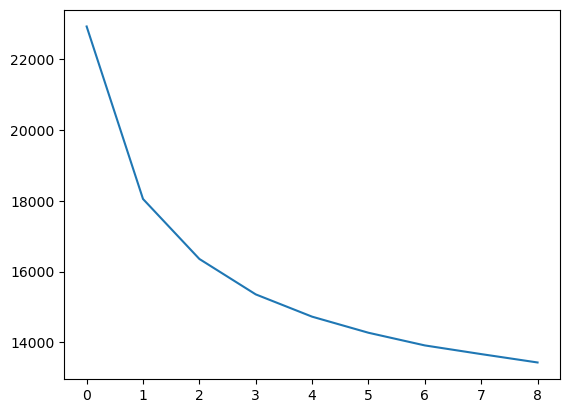

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

### Evaluating the Results

In [15]:
correct = 0
for i in range(0, len(X_test)):
    hidden = rnn.initHidden()
    
    name = X_test[i]
    
    for c in name:
        x = letterToTensor(c)
        output, hidden = rnn(x, hidden)
    
    prediction = torch.argmax(output, 1).item()
    
    category = y_test[i]
    category_index = all_categories.index(category)
    
    if category_index == prediction:
        correct += 1
    
print("Accuracy: ", correct/len(X_test))   

Accuracy:  0.7469489414694894


Running on User Input
---------------------




In [16]:
def predict(input_line, n_predictions=5):
    print('\n> %s' % input_line)
    
    hidden = rnn.initHidden()

    for c in input_line:
        x = letterToTensor(c)
        output, hidden = rnn(x, hidden)

    # Get top N categories
    output = torch.softmax(output, 1)
    topv, topi = output.topk(n_predictions, 1, True)
    for i in range(n_predictions):
        value = topv[0][i].item()
        category_index = topi[0][i].item()
        print('(%.2f) %s' % (value, all_categories[category_index]))

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(0.91) Russian
(0.04) English
(0.03) Czech
(0.01) Polish
(0.00) Greek

> Jackson
(0.62) English
(0.22) Russian
(0.05) Scottish
(0.02) Czech
(0.02) French

> Satoshi
(0.49) Japanese
(0.11) Arabic
(0.10) Russian
(0.07) Italian
(0.07) Polish
